## M.bovis/MTB add new product annotations

### August 2019

This notebook finds all unknown proteins in the mtb genome and annotates in the following steps:

* integrate PATRIC, reference and new Doerks annotations in one table
* combine the annotation field into one a single column that covers all of them in order of preference
* blast remaining unknowns to nr/pdb and take take top coverage hit - is it close enough to use
* map mbovis tags to the rv tags and use the new annotations to update Mbovis.
* write the new file to embl format

References:

* Anand P, Sankaran S, Mukherjee S, Yeturu K, Laskowski R, et al. (2011) Structural Annotation of Mycobacterium tuberculosis Proteome. PLOS ONE 6(10): e27044. https://doi.org/10.1371/journal.pone.0027044
* Malone, Kerri M et al. “Updated Reference Genome Sequence and Annotation of Mycobacterium bovis AF2122/97” Genome announcements vol. 5,14 e00157-17. 6 Apr. 2017, doi:10.1128/genomeA.00157-17
* Doerks T, van Noort V, Minguez P, Bork P (2012) Annotation of the M. tuberculosis Hypothetical Orfeome: Adding Functional Information to More than Half of the Uncharacterized Proteins. PLOS ONE 7(4): e34302. https://doi.org/10.1371/journal.pone.0034302

## Links

* https://www.ebi.ac.uk/ena/data/view/LT708304
* https://www.ebi.ac.uk/cgi-bin/sva/sva.pl?search=Go&amp;query=LT708304
* https://www.ncbi.nlm.nih.gov/genome/?term=h37rv
* https://mycobrowser.epfl.ch/
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5383904/

In [3]:
import os, math, time, pickle, subprocess
from importlib import reload
from collections import OrderedDict
import numpy as np
import pandas as pd
pd.set_option('display.width', 140)
pd.set_option('display.max_colwidth', 80)

from Bio import SeqIO
import epitopepredict as ep
from epitopepredict import sequtils, utilities
from IPython.display import display, HTML, Image
%matplotlib inline
import matplotlib as mpl
import pylab as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.4)
plt.rcParams['savefig.dpi']=130

In [4]:
labels=['hypothetical protein','conserved protein','conserved hypothetical','unknown protein','uncharacterized','hypothetical alanine']
def find_annotated(x):
    for l in labels:
        if l in str(x).lower() or x is np.nan:
            return False 
    return True

def get_locus_tag(x):
    s=str(x).split(' ')
    for i in s:
        if i.startswith('Rv'):
            return i
    
def get_rv_patric(x):
    s=str(x).split('_')    
    if len(s)>1:
        return 'Rv'+s[1]

## summary of current annotations

In [7]:
reload(sequtils)
genomes={'Mbovis AF2122/97':'LT708304_updated_25-05-18.embl', #'Mbovis Strain SP38':'Mbovis_ASM93432v3.gb',
         'MTB-H37Rv (Reference)':'MTB-H37Rv_AL123456.3.gb',
         'MTB-H37Rv (Broad)':'MTB-H37Rv_ASM27773v2.gb'}
d={}
for g in genomes:
    print (g)
    if g == 'Mbovis AF2122/97':
        df = sequtils.embl_to_dataframe(genomes[g])
    else:
        df = sequtils.genbank_to_dataframe(genomes[g])
    #print (df[:5])  
    coding = df[df.type=='CDS']
    notrans = coding[coding.translation.isnull()]
    #print (notrans[['locus_tag','gene','translation','pseudo']])
    s = sequtils.features_summary(df)
    #print (df.type.value_counts())
    d[g] = s
d=pd.DataFrame(d).T
cols = ['cds with translations','cds with gene names','hypothetical','pseudogenes']
d.to_csv('mtb_genomes_summary.csv')
d#[cols]

Mbovis AF2122/97
MTB-H37Rv (Reference)
MTB-H37Rv (Broad)


,total features,coding sequences,cds with translations,cds with gene names,hypothetical,pseudogenes,trna,repeat_region,no locus tags,mean sequence length
Mbovis AF2122/97,8297,4000,3989,1961,1097,11,45,107,33,330
MTB-H37Rv (Reference),8541,4031,4018,1953,1097,0,45,262,263,333
MTB-H37Rv (Broad),8176,4036,4036,0,861,7,45,0,1,331


In [8]:
myco=pd.read_csv('mycobrowser_MTB.csv')
#print (len(myco))
g = (myco.groupby(['Functional_Category','Product']).agg({'locus_tag':np.size}))
pc = myco.Functional_Category.value_counts()
#print (pc)
#ax=pc.plot.pie(figsize=(12,8),fontsize=14,wedgeprops=dict(width=0.5),)
#ax.set_title('functional categories of M.Tb proteins (Mycobrowser)',fontsize=22)
#plt.tight_layout()
#plt.savefig('mtb_functional_cats.png')

## Uniprot

In [9]:
uniprot = pd.read_csv('uniprot_MTB.csv')
uniprot['locus_tag'] = uniprot['Gene names'].apply(lambda x: get_locus_tag(x), 1)
uniprot['gene'] = uniprot['Gene names'].apply(lambda x: str(x).split(' ')[0], 1)
#uniprot['function'] = uniprot.apply(get_category,1)
uniprot = uniprot[['locus_tag','product','Entry','gene']]
#print (uniprot[:50])

## PATRIC

In [10]:
patric=pd.read_csv('patric_MTB-H37Rv.csv')
#patric['locus_tag']=patric.refseq_locus_tag.apply(lambda x: get_rv_patric(x),1)
print (len(patric))
#pu = patric[~patric.locus_tag.isin(mtb.locus_tag)]
#pu['AA Length'].hist(bins=30)

4367


## Doerks dataset

In [11]:
doerks = pd.read_csv('doerks.csv')
#remove proteins definitions that are too vague
doerks =  doerks[~doerks.product_doerks.str.contains('process')]
print (len(doerks))

543


## combine annotations from multiple sources

In [12]:
reload(sequtils)
mtb = sequtils.genbank_to_dataframe('MTB-H37Rv_AL123456.3.gb',cds=True)

mtb = mtb.merge(patric,on='locus_tag',how='left',suffixes=['','_patric'])
mtb = mtb.merge(myco,on='locus_tag',how='left',suffixes=['','_myco'])
mtb = mtb.merge(uniprot, on='locus_tag', how='left',suffixes=['','_uniprot'])
mtb = mtb.merge(doerks,on='locus_tag',how='left',suffixes=['','_doerks'])
print (len(mtb))

mtb['ref_annotated'] = mtb['product'].apply(find_annotated,1)
mtb['patric_annotated'] = mtb.product_patric.apply(find_annotated,1)
mtb['doerks_annotated'] = ~mtb.product_doerks.isnull()
mtb['uniprot_annotated'] = mtb.product_uniprot.apply(find_annotated,1)

pmodel = pd.read_csv('journal.pone.0027044.s014.CSV')
pmodel['PDB_4'] = pmodel.PDB_ID.apply(lambda x: str(x)[:4].upper(),1)
#pmodel.confidence.value_counts()
#print (pmodel[:50])
mtb = mtb.merge(pmodel,on='locus_tag',how='left')
mtb.to_csv('annotations_combined.csv')

cols=['locus_tag','product','product_patric']
#print (mtb[(mtb.patric_annotated == False) & (mtb.myc_annotated == True)][cols])
print (mtb.ref_annotated.value_counts())


4030
True     2974
False    1089
Name: ref_annotated, dtype: int64


## create final column combining all annotations for unknowns

In [13]:
def add_annotation(x):
    #get annotations in order of preference
    if x.ref_annotated is True:
        return x['product']        
    elif x.patric_annotated is True:
        return x.product_patric
    elif x.doerks_annotated is True:
        return x.product_doerks
    elif x.uniprot_annotated is True:
        return x.product_uniprot
    else:
        return x['product']

mtb['final'] = mtb.apply(add_annotation,1)
#print (mtb.final.value_counts()[:8])
#print (mtb['product'].value_counts()[:8])

mtb['final_annotated'] = mtb.final.apply(find_annotated,1)
print (mtb.final_annotated.value_counts())
mtb.to_csv('annotations_combined.csv',index=False)

True     3625
False     438
Name: final_annotated, dtype: int64


## Blast remaining unknowns to the PDB

We use this result at the end to add these missing annotations to the final list.

In [ ]:
reload(sequtils)
remaining = mtb[(mtb.final_annotated == False)]
print (len(remaining))
seqs = remaining.translation

'''db='pdb'
st=time.time()
bl=sequtils.blast_sequences(db,seqs,labels=remaining.locus_tag)
bl.to_csv('unknowns_blast_%s.csv' %db,index=False)
print (time.time()-st)'''

bl=pd.read_csv('unknowns_blast_pdb.csv')

def get_best_hits(bl):
    cols=['stitle','sseqid','qcovs','pident','length','sseq']
    best = bl.sort_values('qcovs',ascending=False).groupby('qseqid').first()[cols]
    best = best.sort_values(['qcovs','pident'],ascending=False)
    best = best[(best.pident>60) & (best.qcovs>60)]
    best=best.reset_index()
    return best

best = get_best_hits(bl)
best.to_csv('unknowns_pdb_hits.csv')
#best[:4]

## Get Anand HIGH confidence results for remaining unknowns  **not used

In [ ]:
def get_pdb_descriptions(ids):
    import requests
    from io import StringIO    
    pdbstr = ','.join(ids)
    #print (pdbstr)
    pdbrest = 'http://www.rcsb.org/pdb/rest/customReport.xml?'\
    'pdbids=%s&customReportColumns=chainLength,uniprotRecommendedName,geneName,taxonomy&service=wsfile&format=csv' %pdbstr
    r = requests.get(pdbrest)
    data = r.text
    #print (data)    
    df = pd.read_csv(StringIO(data))    
    return df

In [ ]:
#this info wasn't used in the final annotation
ids = remaining.PDB_4.dropna()
pdb_data = get_pdb_descriptions(ids)
pdb_data=pdb_data.drop_duplicates('structureId')
x = pmodel.merge(pdb_data,left_on='PDB_4',right_on='structureId',how='inner')
x = x[x.confidence=='HIGH']

## overlap of unknowns

543


/usr/local/lib/python3.8/dist-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


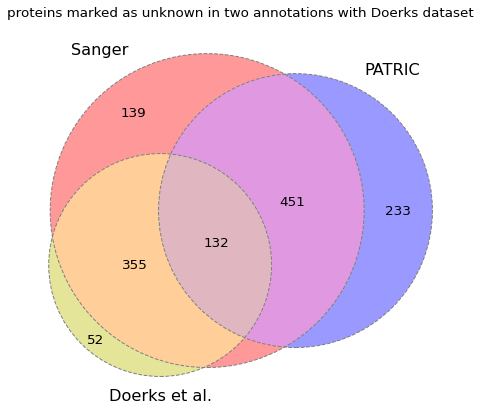

In [20]:
print (len(doerks))
pa = mtb[(mtb.patric_annotated == 0)].locus_tag
ref = mtb[mtb.ref_annotated == 0].locus_tag
do = doerks.locus_tag

f,ax=plt.subplots(1,1,figsize=(8,8))
utilities.venndiagram([ref,pa,do],['Sanger','PATRIC','Doerks et al.'],ax=ax,colors=['r','b','y'])
from matplotlib_venn import venn3_circles
c=venn3_circles((set(ref),set(pa),set(do)), linestyle='dashed', linewidth=1, color="grey")

ax.set_title('proteins marked as unknown in two annotations with Doerks dataset')
#unknown.length.hist(bins=30,lw=1,ec='black',grid=False,figsize=(12,5))
#ax.set_title('length distribution of unknown M.tb proteins')

plt.savefig('mtb_unknowns.svg')

# Mbovis AF2122/97 updates

Notes: 

* current version on INSDC has missing genes, this update should also fix that.
* the new genome sequence is PRJEB15187 and has BQ2027 registered at the locus tag prefix

#### Changes done by Joe to LT708304.1:

* added repeat_regions back
* The following genes were present in the original annotation and have been re-inserted.

    MB0025
    MB0284C
    MB0608
    MB1408
    MB2086
    RNPB
    SSR

We now use the Rv changes to update the Mbovis annotation where locus tags match:

* add new products
* add new functional categories from doerks paper
* add notes to changed features
* add a \old_locus_tag field to all genes

## Combine with annotations with Mbovis tags using mapping

In [30]:
mapping = pd.read_csv('mbovis_mapping.csv')
def get_new_locus_tag(x):
    if x != None:
        return 'BQ2027_'+str(x).upper().replace('C','c').replace(' ','')
    else:
        return ''

subcols=['locus_tag','gene_uniprot','gene_myco','final','new_category','ref_annotated','final_annotated','confidence','PDB_ID', 'SCOP_ID','PDB_4']
mapping = mapping.merge(mtb[subcols],left_on='Rv_tag',right_on='locus_tag',how='left')
print (len(mapping))
mapping['locus_tag'] = mapping.Mb_tag.apply(get_new_locus_tag,1)
#mapping['old_locus_tag'] = mapping.Mb_tag
mapping = mapping.drop_duplicates('locus_tag')
mapping = mapping.rename(columns={'final':'product'})
mapping.to_csv('final_mbovis_mapping.csv',index=False)
#print (mapping.locus_tag.value_counts())
#print (mapping.ref_annotated.value_counts())
#print (mapping.final_annotated.value_counts())

#tags with newly added products
new_annot = mapping[(mapping.ref_annotated==False) & (mapping.final_annotated==True)]
print ('%s new products to be added' %len(new_annot.Mb_tag.unique()))
cols = ['locus_tag','gene','Annotation','product']
new_annot[cols].to_csv('new_products.csv',index=False)

4171
611 new products to be added


In [ ]:
def remove_rv(x):
    if type(x) is str and x.startswith('Rv'):
        return
    else:
        return x

new_annot['gene_uniprot'] = new_annot.gene_uniprot.apply(remove_rv)
new_annot.gene_uniprot.value_counts()
new_annot['gene'] = new_annot.gene_uniprot

## Update qualifiers for the newly annotated hypotheticals

In [23]:
def update_features(record, df, field, key='locus_tag', feature_type='CDS', verbose=False):
    """Use a dataframe to update seqrecord features with new or existing qualifier.
    record: input seqrecord with features to update
    df: dataframe with new fields matched by key
    field: column with new data
    key: key to match on
    """
   
    from copy import copy
    record = copy(record)
    index = sequtils.index_genbank_features(record,feature_type,"locus_tag")
    c=0
    print (field,feature_type)
    for i,r in df.iterrows():        
        t=r[key] 
        if t not in index:
            continue
        new = r[field]
        #print (new)      
        if new is None or new == '' or type(new) is not str:
            continue
        if verbose is True:
            #print (r)
            print (t,index[t], new)             
        cds = record.features[index[t]]
        if field not in cds.qualifiers:
            cds.qualifiers[field] = new
            c+=1
        else:
            curr = cds.qualifiers[field][0]            
            if new != curr:
                cds.qualifiers[field] = new
                c+=1
            #else:
            #    print (curr,new)
    print ('updated %s features' %c)
    return record

def append_note(record, names, note):
    """add note to features"""
    
    index = sequtils.index_genbank_features(record,"CDS","locus_tag")  
    for t in names:
        if t not in index:
            continue        
        cds = record.features[index[t]]
        curr = cds.qualifiers['note'][0]
        cds.qualifiers['note'] = curr + ' ' + note 
        #print (cds.qualifiers['note'])
    return record

def fix_pseudo(rec):
    for i in rec.features:
        if 'pseudo' in i.qualifiers:
            i.qualifiers['pseudo'] = None

In [24]:
def fix_locus_tags(rec):
    prefix = 'BQ2027_'
    #remove some repeat_regions gene feats
    for index, feat in enumerate(rec.features):
        q = feat.qualifiers
        if not 'locus_tag' in q:
            continue
        lt = q['locus_tag'][0]            
        if feat.type == 'gene' and lt.startswith('REP'):
            rec.features.pop(index)     
            #print(feat)    
    for index, feat in enumerate(rec.features):
        q = feat.qualifiers
        if not 'locus_tag' in q:
            continue
        lt = q['locus_tag'][0]            
        if lt == 'DR_region' or feat.type == 'repeat_region':
            #print (feat)
            del q['locus_tag']
            #print (feat)
        elif not lt.startswith(prefix) and feat.type != 'repeat_region':
            #print (rec)
            q['locus_tag'] = prefix + q['locus_tag'][0]
            #print (rec)
    return

recs = SeqIO.read('LT708304_updated_25-05-18.embl','embl')
fix_locus_tags(recs)

## Write mbovis to genbank and embl with new feature qualifiers

In [26]:
reload(sequtils)

#print (new_annot.locus_tag[:10])
print (len(new_annot))
print (len(mapping))

#load last previously submitted features from embl file
recs = SeqIO.read('LT708304_updated_25-05-18.embl','embl')

new = update_features(recs, new_annot, 'product')
#update gene names
new = update_features(new, new_annot, 'gene')
#also gene features
new = update_features(new, new_annot, 'gene', feature_type='gene')

#add old_locus_tag qualifier to all
#new = update_features(new, mapping, 'old_locus_tag')

#note = "Updated with new functional annotation from literature."
#new = append_note(feats, un.locus_tag, note)

#add manually edited entries from pdb hits
#manual = pd.read_csv('manual_edits.csv')
#new = update_features(new, manual, 'product', verbose=True)

#add new locus tags for tRNA and insertion sequences
fix_locus_tags(new)

#save the final file
fix_pseudo(new)
SeqIO.write(new, 'new.embl', "embl")


611
3997
product CDS
updated 611 features
gene CDS
updated 69 features
gene gene
updated 69 features


1

In [48]:
new = list(SeqIO.parse('new.embl','embl'))
SeqIO.write(new, 'new.gb', "genbank")
from BCBio import GFF
GFF.write(new, open('new.gff','w'))

## Verify new embl file

In [ ]:
reload(sequtils)
old = sequtils.embl_to_dataframe('LT708304_updated_25-05-18.embl','embl')
new = sequtils.embl_to_dataframe('new.embl','embl')
print (sequtils.features_summary(old))
print (sequtils.features_summary(new))
print (old.type.value_counts())
print (new.type.value_counts())

## patric extra genes not in reference mbovis

In [ ]:
patric_mb=pd.read_csv('patric_Mbovis.csv')
new_patric = patric_mb[patric_mb.locus_tag.isnull()]
print (new_patric[:4])
#print (len(new_patric))
df=sequtils.fasta_to_dataframe('patric_Mbovis.faa')
df['id'] = df.locus_tag.apply(lambda x: x.split('_Mb')[0].replace('_','|'),1)
#df[:5]
df=df[df.id.isin(new_patric['PATRIC ID'])]
#print (df)
#pbl=sequtils.blast_sequences('swissprot',df.translation,labels=df.locus_tag)
#pbl.to_csv('new_patric_blast_swissprot.csv')

## create alt gff for using with bcftools csq

In [ ]:
def GFF_bcftools_format(recs, out_file):
    """Convert a bacterial genbank file from NCBI to a GFF3 format that can be used in bcftools csq.
    see https://github.com/samtools/bcftools/blob/develop/doc/bcftools.txt#L1066-L1098.
    Args:
        recs: input records
        out_file: name of GFF file
    """

    from BCBio import GFF    
    out_handle = open(out_file, "w")
    from Bio.SeqFeature import SeqFeature
    from Bio.SeqFeature import FeatureLocation
    from copy import copy

    for record in recs:
        #make a copy of the record as we will be changing it during the loop
        new = copy(record)
        new.features = []
        #loop over all features
        for i in range(0,len(record.features)):          
            feat = record.features[i]
            q = feat.qualifiers
            #remove some unecessary qualifiers
            for label in ['note','translation','product','experiment']:
                if label in q:
                    del q[label]
            try:
                if(feat.type == "CDS"):
                    #use the CDS feature to create the new lines
                    tag = q['locus_tag'][0]
                    q['ID'] = 'CDS:%s' %tag
                    q['Parent'] = 'transcript:%s' %tag
                    q['biotype'] = 'protein_coding'

                    #create mRNA feature
                    m = SeqFeature(feat.location,type='mRNA',strand=feat.strand)
                    q = m.qualifiers
                    q['ID'] = 'transcript:%s' %tag
                    q['Parent'] = 'gene:%s' %tag
                    q['biotype'] = 'protein_coding'
                    new.features.append(m)

                elif(record.features[i].type == "gene"):
                    #edit the gene feature
                    q=feat.qualifiers               
                    q['ID'] = 'gene:%s' %q['locus_tag'][0]
                    q['biotype'] = 'protein_coding'
                    if 'gene' in q:
                        q['Name'] = q['gene']
            except:
                print (q)
                continue
            new.features.append(feat)
        #write the new features to a GFF                                      
        GFF.write([new], out_handle)
        return

GFF_bcftools_format(new, 'new_csq_format.gff')